## Cost Aware Assignment Problem

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

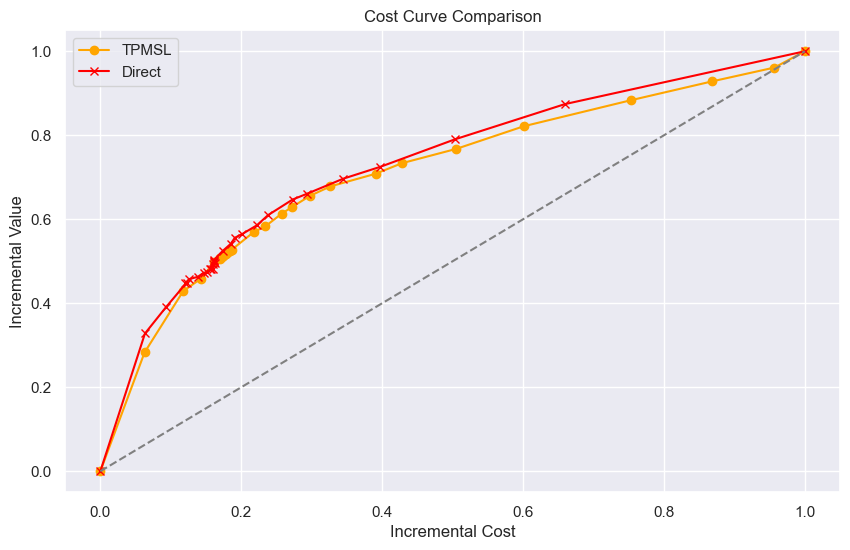

In [1]:
import cost_aware
cost_aware.main()

## Cost Unaware Treament Assignment Problem

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 9785714, number of used features: 14
[LightGBM] [Info] Start training from score 0.046992
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 1467856, number of used features: 12
[LightGBM] [Info] Start training from score 0.038205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

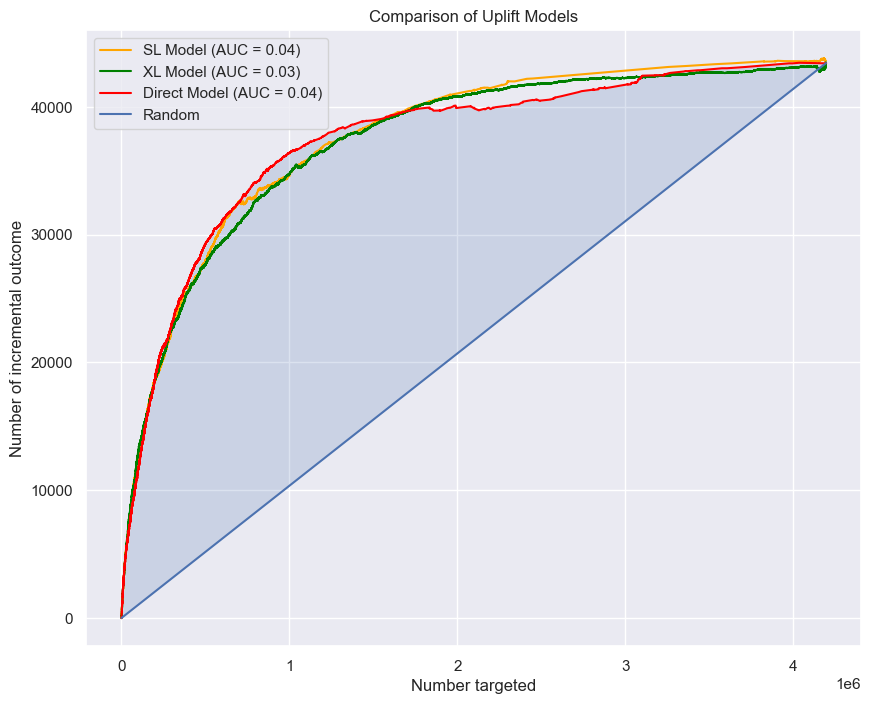

SL Model: 0.03568733407492502
XL Model: 0.03481139207106486
Direct Model: 0.03507166479387236


In [1]:
import cost_unaware
cost_unaware.main()

In [45]:
0.03507166479387236/0.03568733407492502

0.982748241161414

In [46]:
0.8749/0.8440

1.0366113744075829

### Causal Forest

In [16]:
# # causal forest での効果の推定
# from econml.dml import CausalForestDML
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from statsmodels.nonparametric.kernel_regression import KernelReg

# # モデルの構築
# cf = CausalForestDML(model_y=LinearRegression(),
#                      model_t=LogisticRegression(),
#                      discrete_treatment=True,
#                      n_estimators=4)
# cf.fit(y_train, T_train, X=X_train)

# # 効果の推定
# tau_cf = cf.effect(X_test)